<a href="https://colab.research.google.com/github/kirubanath/NLP/blob/main/BertSmall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Fine-tuning BERT To Perform Common Sense Reasoning

## June 20, 2023

Welcome to the Lab 2 of our course on Natural Language Processing. As the name suggests in this lab you will learn how to fine-tune a pretrained model like BERT on a downstream task to improve much more superior performance compared to the methods discussed so far. We will be working with the [SocialIQA](https://arxiv.org/abs/1904.09728) dataset this week, which is a multiple choice classification dataset designed to learn and measure social and emotional intelligence in NLP models.


This assignment will also make heavy use of the [🤗 Transformers Library](https://huggingface.co/docs/transformers/index). Don't worry if you are not familiar with the library, we will discuss its usage in detail.

Note: Access to a GPU will be crucial for working on this assignment. So do select a GPU runtime in Colab before you start working.

Learning Outcomes from this Lab:
- Learn how to use 🤗 Transformer library to load and fine-tune pre-trained langauge models
- Learn how to solve common sense reasoning problems using Masked Language Models like BERT

Suggested Reading:
- [Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*](https://arxiv.org/pdf/1810.04805.pdf)
- [Maarten Sap, Hannah Rashkin, Derek Chen, Ronan Le Bras, and Yejin Choi. 2019. Social IQa: Commonsense Reasoning about Social Interactions. In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), pages 4463–4473, Hong Kong, China. Association for Computational Linguistics.] (https://arxiv.org/pdf/1810.04805.pdf)

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    siqa_data_dir = "gdrive/MyDrive/PlakshaNLP2023/Lab2/data/socialiqa-train-dev/"
except:
    siqa_data_dir = "/datadrive/t-kabir/work/repos/PlakshaNLP/TLPNLP2023/source/Lab2/data/socialiqa-train-dev/"

Mounted at /content/gdrive


In [2]:
# Install required libraries
!pip install numpy
!pip install pandas
!pip install torch
!pip install tqdm
!pip install matplotlib
!pip install transformers
!pip install scikit-learn
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pub

In [3]:
# We start by importing libraries that we will be making use of in the assignment.
import os
from functools import partial
import json
from pprint import pprint
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
from tqdm.notebook import tqdm

from transformers.utils import logging
logging.set_verbosity(40) # to avoid warnings from transformers

## SocialIQA Dataset

We start by discussing the dataset that we will making use of in today's Lab. As described above SocialIQA was designed to learn and measure social and emotional intelligence in NLP models. It is a multiple choice classification task, where you are given a context of some social situation, a question about the context and then three possible answers to the questions. The task is to predict which of the three options answers the question given the context.

![siqa dataset](https://i.ibb.co/s5tMpY8/siqa.png)

Below we load the dataset in memory

In [4]:
def load_siqa_data(split):

    # We first load the file containing context, question and answers
    with open(f"/content/gdrive/MyDrive/PlakshaNLP2023/Lab2/data/socialiqa-train-dev/{split}.jsonl") as f:
        data = [json.loads(jline) for jline in f.read().splitlines()]


    # We then load the file containing the correct answer for each question
    with open(f"/content/gdrive/MyDrive/PlakshaNLP2023/Lab2/data/socialiqa-train-dev/{split}-labels.lst") as f:
        labels = f.read().splitlines()

    labels_dict = {"1": "A", "2": "B", "3": "C"}
    labels = [labels_dict[label] for label in labels]

    return data, labels


train_data, train_labels = load_siqa_data("train")
dev_data, dev_labels = load_siqa_data("dev")

print(f"Number of Training Examples: {len(train_data)}")
print(f"Number of Validation Examples: {len(dev_data)}")

Number of Training Examples: 33410
Number of Validation Examples: 1954


<Axes: ylabel='count'>

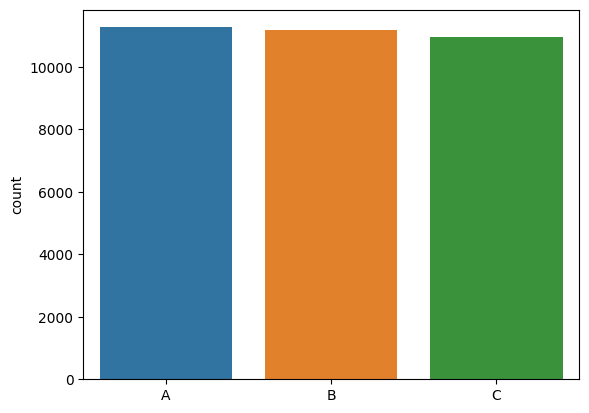

In [5]:
sns.countplot(x = train_labels)

In [6]:
# View a sample of the dataset
print("Example from dataset")
pprint(train_data[100], sort_dicts=False, indent=4)
print(f"Label: {train_labels[100]}")

Example from dataset
{   'context': "Jordan's dog peed on the couch they were selling and Jordan "
               'removed the odor as soon as possible.',
    'question': 'How would Jordan feel afterwards?',
    'answerA': 'selling a couch',
    'answerB': 'Disgusted',
    'answerC': 'Relieved'}
Label: B


In [7]:
train_data[500]

{'context': 'kendall was a person who kept her word so she got my money the other day.',
 'question': 'What will Others want to do next?',
 'answerA': 'resent kendall',
 'answerB': 'support kendall',
 'answerC': 'hate kendall'}

## Task 1: Tokenization and Data Preperation (1 hour)

As discussed in the lectures, BERT and other pretrained language models use sub-word tokenization i.e. individual words can also be split into constituent subwords to reduce the vocabulary size. The Transformer library provides tokenizer for all the popular language models. Below we demonstrate how to create and use these tokenizers.

In [8]:
# Import the BertTokenizer from the library
from transformers import BertTokenizer

# Load a pre-trained BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

`BertTokenizer.from_pretrained` is used to load a pre-trained tokenizer. Notice that we provide the argument `"bert-base-uncased"` to the method. This refers to the variant of BERT that we want to use. The term "base" means we want to use the smaller BERT variant i.e. the one with 12 layers, and "uncased" refers to the fact that it treats upper-case and lower-case characters identically. There are 4 variants available for BERT which are:
    - `bert-base-uncased`
    - `bert-base-cased`
    - `bert-large-uncased`
    - `bert-large-cased`
Now that we have loaded the tokenizer, let's see how to use it.

`tokenize` method can be used to split the text into sequence of tokens

In [9]:
bert_tokenizer.tokenize("kendall was a person who kept her word exquisitely, so she got my money the other day")

['kendall',
 'was',
 'a',
 'person',
 'who',
 'kept',
 'her',
 'word',
 'exquisite',
 '##ly',
 ',',
 'so',
 'she',
 'got',
 'my',
 'money',
 'the',
 'other',
 'day']

Notice how the tokenizer not only splits the text into words but also subwords like "exquisitely" is split into "exquisite" and "ly".

Another use case of the tokenizer is to convert the tokens into indices. This is important because BERT and almost all language models takes as the inputs a sequence of token ids, which they use to map into embeddings. `convert_tokens_to_ids` method can be used to do this

In [10]:
sentence = "kendall was a person who kept her word exquisitely, so she got my money the other day"
tokens = bert_tokenizer.tokenize(sentence)
token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[14509, 2001, 1037, 2711, 2040, 2921, 2014, 2773, 19401, 2135, 1010, 2061, 2016, 2288, 2026, 2769, 1996, 2060, 2154]


The two steps can also be combined by simply calling the tokenizer object

In [11]:
pprint(bert_tokenizer(sentence), sort_dicts=False, indent=4)

{   'input_ids': [   101,
                     14509,
                     2001,
                     1037,
                     2711,
                     2040,
                     2921,
                     2014,
                     2773,
                     19401,
                     2135,
                     1010,
                     2061,
                     2016,
                     2288,
                     2026,
                     2769,
                     1996,
                     2060,
                     2154,
                     102],
    'token_type_ids': [   0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          0,
                          

Notice that it returns a bunch of things in addition to the ids. The `"input_ids"` are just the token ids that we obtained in the previous cell. However you will notice that it has a few additional ids, it starts with 101 and ends with 102. These are what we call special tokens and correspond the \[CLS\] and \[SEP\] tokens used by BERT. \[CLS\] token is mainly added to beginning of each sequence, and its representations are used to perform sequence classification. More on \[SEP\] token later.

`"token_type_ids"` contains which sequence does a particular token belongs to.

`"attention_mask`" is a mask vector that indicates if a particular token corresponds to padding. Padding is extremely important when we are dealing with variable length sequences, which is almost always the case. Through padding we can ensure that all the sequences in a batch are of same size. However, while processing the sequence we need ignore these padding tokens, hence a mask is required to identify such tokens.

We can tokenize a batch of sequences by just providing a list instead of a string while calling the tokenizer and later pad them using the `.pad` method.

In [12]:
batch_size = 4
sentence_batch = [train_data[i]["context"] for i in range(batch_size)]

#Tokenize the batch of sequences
tokenized_batch = bert_tokenizer(sentence_batch)

# Pad the tokenized batch
tokenized_batch_padded = bert_tokenizer.pad(tokenized_batch, padding=True, max_length=32, return_tensors="pt")

input_ids = tokenized_batch_padded["input_ids"]
attn_mask = tokenized_batch_padded["attention_mask"]
print(f"Input Ids shape: {input_ids.shape}")
print(f"Attention Mask shape: {attn_mask.shape}")

pprint(f"Input Ids:\n {input_ids}\n")
pprint(f"Attention Mask:\n {attn_mask}\n")

Input Ids shape: torch.Size([4, 23])
Attention Mask shape: torch.Size([4, 23])
('Input Ids:\n'
 ' tensor([[  101,  7232,  2787,  2000,  2031,  1037, 26375,  1998,  5935,  '
 '2014,\n'
 '          2814,  2362,  1012,   102,     0,     0,     0,     0,     0,     '
 '0,\n'
 '             0,     0,     0],\n'
 '        [  101,  5553,  2734,  2000,  2507,  2041,  5841,  2005,  2019,  '
 '9046,\n'
 '          2622,  2012,  2147,  1012,   102,     0,     0,     0,     0,     '
 '0,\n'
 '             0,     0,     0],\n'
 '        [  101, 22712,  2001,  2019,  6739, 19949,  1998,  2001,  2006,  '
 '1996,\n'
 '          2300,  2007, 11928,  1012, 22712, 17395,  2098, 11928,  1005,  '
 '1055,\n'
 '          8103,  1012,   102],\n'
 '        [  101, 18403,  2435,  1037,  8549,  2000, 27970,  1005,  1055,  '
 '2365,\n'
 '          2043,  2027,  2020,  3110,  2091,  1012,   102,     0,     0,     '
 '0,\n'
 '             0,     0,     0]])\n')
('Attention Mask:\n'
 ' tensor([[1, 1, 1, 1, 1, 1, 1, 

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Notice how 0s get appended to the input ids sequence, and the same is also reflected in the output of `attn_mask` where `0` indicates that the particular token was padded and `1` means otherwise. Setting `return_tensors="pt"` results in the outputs as torch tensors

Finally, for tasks involving reasoning over multiple sentences (like what we have for the SocialIQA dataset), it is common to seperate out each sentence using a \[SEP\] token:

<img src="https://i.ibb.co/Nx8mK1P/bert-sentence-pair.jpg" alt="bert-sentence-pair" border="0">

We can achieve this by adding concatenating all sentences with the `[SEP]` token before calling the tokenizer

In [13]:
example = train_data[100]
context = example["context"]
question = example["question"]
answerA = example["answerA"]

# Concatenate the context, question and answerA
cqa = context + bert_tokenizer.sep_token + question + bert_tokenizer.sep_token + answerA
print(cqa)

tokenized_cqa = bert_tokenizer(cqa)
pprint(tokenized_cqa, sort_dicts=False, indent=4)

Jordan's dog peed on the couch they were selling and Jordan removed the odor as soon as possible.[SEP]How would Jordan feel afterwards?[SEP]selling a couch
{   'input_ids': [   101,
                     5207,
                     1005,
                     1055,
                     3899,
                     21392,
                     2094,
                     2006,
                     1996,
                     6411,
                     2027,
                     2020,
                     4855,
                     1998,
                     5207,
                     3718,
                     1996,
                     19255,
                     2004,
                     2574,
                     2004,
                     2825,
                     1012,
                     102,
                     2129,
                     2052,
                     5207,
                     2514,
                     5728,
                     1029,
                     102,
        

For the reasons that will become clear once we work on the modeling part, we need three input tensors for each dataset example, one for concatenating each answer with the context and question.

In [14]:
example = train_data[100]
context = example["context"]
question = example["question"]
answerA = example["answerA"]
answerB = example["answerB"]
answerC = example["answerC"]

cqaA = context + bert_tokenizer.sep_token + question + bert_tokenizer.sep_token + answerA
cqaB = context + bert_tokenizer.sep_token + question + bert_tokenizer.sep_token + answerB
cqaC = context + bert_tokenizer.sep_token + question + bert_tokenizer.sep_token + answerC

print(cqaA)
print(cqaB)
print(cqaC)

tokenized_cqaA = bert_tokenizer(cqaA)
tokenized_cqaB = bert_tokenizer(cqaB)
tokenized_cqaC = bert_tokenizer(cqaC)


Jordan's dog peed on the couch they were selling and Jordan removed the odor as soon as possible.[SEP]How would Jordan feel afterwards?[SEP]selling a couch
Jordan's dog peed on the couch they were selling and Jordan removed the odor as soon as possible.[SEP]How would Jordan feel afterwards?[SEP]Disgusted
Jordan's dog peed on the couch they were selling and Jordan removed the odor as soon as possible.[SEP]How would Jordan feel afterwards?[SEP]Relieved


## Task 1.1: Custom Dataset Class

Now that we know how to use the hugging face tokenizers we can define the custom `torch.utils.Dataset` class like we did in the previous assignments to process and store the data as well as provides a way to iterate through the dataset. Implement the `SIQABertDataset` class below. Recall to create a custom class you need to implement 3 methods `__init__`, `__len__` and `__getitem__`.

In [15]:
from torch.utils.data import Dataset, DataLoader

class SIQABertDataset(Dataset):

    def __init__(self, data, labels, bert_variant = "bert-base-uncased"):
        """
        Constructor for the `SST2BertDataset` class. Stores the `sentences` and `labels` which can then be used by
        other methods. Also initializes the tokenizer

        Inputs:
            - data (list) : A list SIQA dataset examples
            - labels (list): A list of labels corresponding to each example
            - bert_variant (str): A string indicating the variant of BERT to be used.
        """
        self.label2label_id = {"A": 0, "B": 1, "C": 2}
        self.data = data
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained(bert_variant)



    def __len__(self):
        """
        Returns the length of the dataset
        """
        length = len(self.data)
        return length

    def __getitem__(self, idx):
        """
        Returns the training example corresponding to review present at the `idx` position in the dataset

        Inputs:
            - idx (int): Index corresponding to the review,label to be returned

        Returns:
            - tokenized_input_dict (dict(str, dict)): A dictionary corresponding to tokenizer outputs for the three resulting sequences due to each answer choices as described above
            - label (int): Answer label for the corresponding sentence. We will use 0, 1 and 2 to represent A, B and C respectively.

        Example Output:
            - tokenized_input_dict: {
                "A": {'input_ids': [101, 5207, 1005, 1055, 3899, 21392, 2094, 2006, 1996, 6411, 2027, 2020, 4855, 1998, 5207, 3718, 1996, 19255, 2004, 2574, 2004, 2825, 1012, 102, 2129, 2052, 5207, 2514, 5728, 1029, 102, 4855, 1037, 6411, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
                "B": {'input_ids': [101, 5207, 1005, 1055, 3899, 21392, 2094, 2006, 1996, 6411, 2027, 2020, 4855, 1998, 5207, 3718, 1996, 19255, 2004, 2574, 2004, 2825, 1012, 102, 2129, 2052, 5207, 2514, 5728, 1029, 102, 17733, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
                "C": {'input_ids': [101, 5207, 1005, 1055, 3899, 21392, 2094, 2006, 1996, 6411, 2027, 2020, 4855, 1998, 5207, 3718, 1996, 19255, 2004, 2574, 2004, 2825, 1012, 102, 2129, 2052, 5207, 2514, 5728, 1029, 102, 7653, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
            }
            - label: 0

        """

        data = self.data[idx]
        tokenized_input_dict = {f"{x}":self.tokenizer(data["context"] + self.tokenizer.sep_token + data["question"] + self.tokenizer.sep_token + data[f"answer{x}"]) for x in ['A','B','C']}

        label = self.label2label_id[self.labels[idx]]


        return tokenized_input_dict, label

In [16]:
print("Running Sample Test Cases")

sample_dataset = SIQABertDataset(train_data[:2], train_labels[:2], bert_variant="bert-base-uncased")

print(f"Sample Test Case 1: Checking if `__len__` is implemented correctly")
dataset_len= len(sample_dataset)
expected_len = 2
print(f"Dataset Length: {dataset_len}")
print(f"Expected Length: {expected_len}")
assert len(sample_dataset) == expected_len
print("Sample Test Case Passed!")
print("****************************************\n")

print(f"Sample Test Case 2: Checking if `__getitem__` is implemented correctly for `idx= 0`")
sample_idx = 0
tokenized_input_dict, label = sample_dataset.__getitem__(sample_idx)
expected_tokenized_input_dict = {'A': {'input_ids': [101, 7232, 2787, 2000, 2031, 1037, 26375, 1998, 5935, 2014, 2814, 2362, 1012, 102, 2129, 2052, 2500, 2514, 2004, 1037, 2765, 1029, 102, 2066, 7052, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
  'B': {'input_ids': [101, 7232, 2787, 2000, 2031, 1037, 26375, 1998, 5935, 2014, 2814, 2362, 1012, 102, 2129, 2052, 2500, 2514, 2004, 1037, 2765, 1029, 102, 2066, 6595, 2188, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
  'C': {'input_ids': [101, 7232, 2787, 2000, 2031, 1037, 26375, 1998, 5935, 2014, 2814, 2362, 1012, 102, 2129, 2052, 2500, 2514, 2004, 1037, 2765, 1029, 102, 1037, 2204, 2767, 2000, 2031, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}
expected_label = 0
print(f"tokenized_input_dict:\n {tokenized_input_dict}")
print(f"Expected tokenized_input_dict:\n {expected_tokenized_input_dict}")
assert (expected_tokenized_input_dict == tokenized_input_dict)

print(f"label:\n {label}")
print(f"Expected label:\n {expected_label}")
assert expected_label == label

print("Sample Test Case Passed!")
print("****************************************\n")


print(f"Sample Test Case 3: Checking if `__getitem__` is implemented correctly for `idx= 1`")
sample_idx = 1
tokenized_input_dict, label = sample_dataset.__getitem__(sample_idx)
expected_tokenized_input_dict =  {'A': {'input_ids': [101, 5553, 2734, 2000, 2507, 2041, 5841, 2005, 2019, 9046, 2622, 2012, 2147, 1012, 102, 2054, 2097, 2500, 2215, 2000, 2079, 2279, 1029, 102, 21090, 2007, 5553, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
                                  'B': {'input_ids': [101, 5553, 2734, 2000, 2507, 2041, 5841, 2005, 2019, 9046, 2622, 2012, 2147, 1012, 102, 2054, 2097, 2500, 2215, 2000, 2079, 2279, 1029, 102, 2131, 2000, 2147, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
                                'C': {'input_ids': [101, 5553, 2734, 2000, 2507, 2041, 5841, 2005, 2019, 9046, 2622, 2012, 2147, 1012, 102, 2054, 2097, 2500, 2215, 2000, 2079, 2279, 1029, 102, 7475, 2007, 1996, 14799, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}


expected_label = 1
print(f"tokenized_input_dict:\n {tokenized_input_dict}")
print(f"Expected tokenized_input_dict:\n {expected_tokenized_input_dict}")
assert (expected_tokenized_input_dict == tokenized_input_dict)

print(f"label:\n {label}")
print(f"Expected label:\n {expected_label}")
assert expected_label == label

print("Sample Test Case Passed!")
print("****************************************\n")

print(f"Sample Test Case 4: Checking if `__getitem__` is implemented correctly for `idx= 0` for a different bert-variant")
sample_dataset = SIQABertDataset(train_data[:2], train_labels[:2], bert_variant="bert-base-cased")
sample_idx = 0
tokenized_input_dict, label = sample_dataset.__getitem__(sample_idx)
expected_tokenized_input_dict = {'A': {'input_ids': [101, 6681, 1879, 1106, 1138, 170, 2927, 3962, 27138, 1105, 5260, 1123, 2053, 1487, 119, 102, 1731, 1156, 8452, 1631, 1112, 170, 1871, 136, 102, 1176, 6546, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 'B': {'input_ids': [101, 6681, 1879, 1106, 1138, 170, 2927, 3962, 27138, 1105, 5260, 1123, 2053, 1487, 119, 102, 1731, 1156, 8452, 1631, 1112, 170, 1871, 136, 102, 1176, 6218, 1313, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 'C': {'input_ids': [101, 6681, 1879, 1106, 1138, 170, 2927, 3962, 27138, 1105, 5260, 1123, 2053, 1487, 119, 102, 1731, 1156, 8452, 1631, 1112, 170, 1871, 136, 102, 170, 1363, 1910, 1106, 1138, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}
expected_label = 0
print(f"tokenized_input_dict:\n {tokenized_input_dict}")
print(f"Expected tokenized_input_dict:\n {expected_tokenized_input_dict}")
assert (expected_tokenized_input_dict == tokenized_input_dict)

print(f"label:\n {label}")
print(f"Expected label:\n {expected_label}")
assert expected_label == label

print("Sample Test Case Passed!")
print("****************************************\n")


Running Sample Test Cases
Sample Test Case 1: Checking if `__len__` is implemented correctly
Dataset Length: 2
Expected Length: 2
Sample Test Case Passed!
****************************************

Sample Test Case 2: Checking if `__getitem__` is implemented correctly for `idx= 0`
tokenized_input_dict:
 {'A': {'input_ids': [101, 7232, 2787, 2000, 2031, 1037, 26375, 1998, 5935, 2014, 2814, 2362, 1012, 102, 2129, 2052, 2500, 2514, 2004, 1037, 2765, 1029, 102, 2066, 7052, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'B': {'input_ids': [101, 7232, 2787, 2000, 2031, 1037, 26375, 1998, 5935, 2014, 2814, 2362, 1012, 102, 2129, 2052, 2500, 2514, 2004, 1037, 2765, 1029, 102, 2066, 6595, 2188, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 

tokenized_input_dict:
 {'A': {'input_ids': [101, 6681, 1879, 1106, 1138, 170, 2927, 3962, 27138, 1105, 5260, 1123, 2053, 1487, 119, 102, 1731, 1156, 8452, 1631, 1112, 170, 1871, 136, 102, 1176, 6546, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'B': {'input_ids': [101, 6681, 1879, 1106, 1138, 170, 2927, 3962, 27138, 1105, 5260, 1123, 2053, 1487, 119, 102, 1731, 1156, 8452, 1631, 1112, 170, 1871, 136, 102, 1176, 6218, 1313, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, 'C': {'input_ids': [101, 6681, 1879, 1106, 1138, 170, 2927, 3962, 27138, 1105, 5260, 1123, 2053, 1487, 119, 102, 1731, 1156, 8452, 1631, 1112, 170, 1871, 136, 102, 170, 1363, 1910, 1

We can now create Dataset instances for both training and dev datasets

In [17]:
train_dataset = SIQABertDataset(train_data, train_labels, bert_variant="bert-base-uncased")
dev_dataset = SIQABertDataset(dev_data, dev_labels, bert_variant="bert-base-uncased")

Before we instantiate the dataloaders for iterating over the dataset like last time, we need define a collate function, that creates batches from a list of dataset examples. In the last class we didn't have to create one, because all of our examples were of the same size, but that's not the case anymore, and we need to pad the sequences so that they all are of same size. We have implemented the collate_fn for you below, but we recommend going through it step by step, as it is used often in practice.

In [18]:
def collate_fn(tokenizer, batch):
    """
    Collate function to be used when creating a data loader for the SIQA dataset.
    :param tokenizer: The tokenizer to be used to tokenize the inputs.
    :param batch: A list of tuples of the form (tokenized_input_dict, label)
    :return: A tuple of the form (tokenized_inputs_dict_batch, labels_batch)
    """

    tokenized_inputsA_batch = []
    tokenized_inputsB_batch = []
    tokenized_inputsC_batch = []
    labels_batch = []
    for tokenized_inputs_dict, label in batch:
        tokenized_inputsA_batch.append(tokenized_inputs_dict["A"])
        tokenized_inputsB_batch.append(tokenized_inputs_dict["B"])
        tokenized_inputsC_batch.append(tokenized_inputs_dict["C"])
        labels_batch.append(label)

    #Pad the inputs
    tokenized_inputsA_batch = tokenizer.pad(tokenized_inputsA_batch, padding=True, return_tensors="pt")
    tokenized_inputsB_batch = tokenizer.pad(tokenized_inputsB_batch, padding=True, return_tensors="pt")
    tokenized_inputsC_batch = tokenizer.pad(tokenized_inputsC_batch, padding=True, return_tensors="pt")

    # Convert labels list to a tensor
    labels_batch = torch.tensor(labels_batch)
    return (
        {"A": tokenized_inputsA_batch["input_ids"], "B": tokenized_inputsB_batch["input_ids"], "C": tokenized_inputsC_batch["input_ids"]},
        {"A": tokenized_inputsA_batch["attention_mask"], "B": tokenized_inputsB_batch["attention_mask"], "C": tokenized_inputsC_batch["attention_mask"]},
        labels_batch
    )


Now that we have defined the collate_fn, lets create the dataloaders. It is common to use smaller batch size while fine-tuning these big models, as they occupy quite a lot of memory.

In [19]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, train_dataset.tokenizer))
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, dev_dataset.tokenizer))

In [20]:
batch_input_ids, batch_attn_mask, batch_labels = next(iter(train_loader))
print(f"batch_input_ids:\n {batch_input_ids}")
print(f"batch_attn_mask:\n {batch_attn_mask}")
print(f"batch_labels:\n {batch_labels}")

batch_input_ids:
 {'A': tensor([[  101, 14673,  2292,  2032,  2067,  1999,  2130,  2295,  2002,  2001,
          1037, 16374,  1998,  1037, 21910,  2121,  1012,   102,  2054,  2515,
         14673,  2342,  2000,  2079,  2077,  2023,  1029,   102,  2005,  1037,
          2117,  3382,   102,     0,     0,     0,     0],
        [  101, 18403,  3764,  2200,  2092,  1997,  2037,  2177,  2130,  2295,
          2027,  2020,  4297, 25377, 12870,  3372,  1012,   102,  2129,  2052,
          2017,  6235, 18403,  1029,   102, 10206,  2007,  2068,   102,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101, 14509,  2218,  5863,  1005,  1055,  3042,  2096,  2027,  2020,
          1999,  1996,  5723,  1012,   102,  2054,  2097,  5863,  2215,  2000,
          2079,  2279,  1029,   102, 17186,  2083,  1996,  3042,   102,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  7546,  2435, 14509,  1037,  5060,  2008,  2027,  2020,  4217,
         

## Task 2: Implementing and Training BERT-based Multiple Choice Classifier (1 hour 30 minutes)

Similar to pretrained tokenizers, the transformers library also provide numerous pre-trained language models that can be fine-tuned on a wide variety of downstream tasks. We demonstrate usage of these models below.

In [21]:
# Import BertModel from the library
from transformers import BertModel

# Create an instance of pretrained BERT
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

As you can see very similar to how we created pre-trained tokenizer, we can load a pretrained BERT model by calling `BertModel.from_pretrained(bert-base-uncased)`. This can actually be considered just a Pytorch `nn.Module` like `nn.Linear` and can be similarly plugged into a network architecture. Also, notice the model contains 12 BERT layers, where each layer consists of a Self Attention layer followed by a sequence of linear layers and activation functions (MLP), as we discussed when talking about Transformer architecture in the lecture.

In [22]:
sentence = "kendall was a person who kept her word exquisitely, so she got my money the other day"
tokenizer_output = bert_tokenizer(sentence, return_tensors="pt")
input_ids, attn_mask = tokenizer_output["input_ids"], tokenizer_output["attention_mask"]

output = bert_model(input_ids, attention_mask = attn_mask)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2823, -0.2353, -0.3529,  ..., -0.0834,  0.2548,  0.4870],
         [ 0.4055, -1.1768, -0.2842,  ..., -0.3740,  0.3920, -0.4480],
         [ 0.0377, -0.7788, -0.1174,  ..., -0.4201, -0.3078,  0.1824],
         ...,
         [-1.1595, -1.5650, -0.2526,  ..., -0.4569, -0.5474,  0.2315],
         [-1.0644, -0.5952, -0.3912,  ...,  0.2788, -0.0207, -0.1262],
         [ 0.5158,  0.4573,  0.0263,  ...,  0.1445, -0.6398, -0.5258]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-7.1342e-01, -3.3350e-01, -4.4551e-01,  4.5434e-01,  5.0347e-01,
         -8.4619e-02,  4.8077e-01,  8.4160e-02, -2.2890e-01, -9.9974e-01,
         -2.4549e-01,  7.9481e-01,  9.8030e-01, -2.8879e-02,  9.1588e-01,
         -2.4135e-01,  5.3666e-01, -5.0656e-01,  2.2218e-01,  3.2123e-01,
          6.4942e-01,  9.9757e-01,  4.7173e-01,  2.0766e-01,  3.6500e-01,
          8.8725e-01, -4.2194e-01,  9.3109e-01,  9.1743e-01,  7.211

As you can see, calling `bert_model` returns a bunch of different things. Let's go through them one by one and understand

In [23]:
last_hidden_state = output.last_hidden_state
print(f"input_ids shape: {input_ids.shape}")
print(f"last_hidden_state shape: {last_hidden_state.shape}")

input_ids shape: torch.Size([1, 21])
last_hidden_state shape: torch.Size([1, 21, 768])


For an input of shape `[1,21]` which just means a single sequence of 21 tokens, last_hidden_state is a tensor of shape `[1, 21, 768]` denoting the contextual embedding of each of the 21 tokens in the sequence. These representations can be then used for solving a downstream task, by adding a linear layer or MLP layer on top. These can be useful for sequence labelling type of tasks.

In [24]:
pooler_output = output.pooler_output
print(f"input_ids shape: {input_ids.shape}")
print(f"pooler_output shape: {pooler_output.shape}")

input_ids shape: torch.Size([1, 21])
pooler_output shape: torch.Size([1, 768])


`pooler_output` is an aggregate representation of the entire sentence and can be thought of as a sentence embedding. It is obtained by passing the representation of the \[CLS\] token through a linear layer. This can be useful for sentence-level tasks like sentiment analysis as well as multiple choice classification tasks etc.

Apart from these two we can also obtain other values by providing additional arguments. Like if we want to obtain attention maps which can be useful for interpretating the model's behavior, we can just specify `output_attentions=True` while calling the model

In [25]:
output = bert_model(input_ids, attention_mask = attn_mask, output_attentions=True)
attentions = output.attentions
print(f"Data type of attentions output: {type(attentions)}")
print(f"Number of elements: {len(attentions)}")
print(f"Shape of individual element: {attentions[0].shape}")
print(f"Example attention map: {attentions[0][0,0]}")

Data type of attentions output: <class 'tuple'>
Number of elements: 12
Shape of individual element: torch.Size([1, 12, 21, 21])
Example attention map: tensor([[0.0365, 0.0188, 0.0239, 0.0918, 0.0375, 0.0409, 0.0390, 0.0327, 0.0256,
         0.0260, 0.0488, 0.0387, 0.0532, 0.0188, 0.0251, 0.0408, 0.0321, 0.0840,
         0.0793, 0.0262, 0.1801],
        [0.0178, 0.0460, 0.0240, 0.0306, 0.0482, 0.0194, 0.0510, 0.0919, 0.0260,
         0.0818, 0.0425, 0.0482, 0.0159, 0.0576, 0.0703, 0.1526, 0.0337, 0.0405,
         0.0194, 0.0371, 0.0454],
        [0.0527, 0.0466, 0.0899, 0.0241, 0.0464, 0.0245, 0.0645, 0.0587, 0.0256,
         0.0401, 0.0298, 0.0606, 0.0302, 0.0735, 0.1222, 0.0573, 0.0297, 0.0204,
         0.0224, 0.0539, 0.0268],
        [0.0425, 0.0528, 0.0454, 0.0338, 0.0402, 0.0353, 0.0515, 0.0666, 0.0397,
         0.0464, 0.0336, 0.0518, 0.0492, 0.0609, 0.0529, 0.0731, 0.0509, 0.0580,
         0.0381, 0.0492, 0.0280],
        [0.0492, 0.1514, 0.0892, 0.0078, 0.0237, 0.0282, 0.0478, 

As you can see `attentions` is a tuple containing 12 elements which corresponds to the attention maps of each of the 12 layers in the network. Further each layer's attention maps also contains 12 attention maps corresponding to 12 heads in each layer. A single attention map as you can see is a 18x18 matrix representing the attention pattern for all the tokens in the sequence

### Task 2.1: Implementing BERT-based Classifier for Multiple Choice Classification

In this task you will implement a bert-based classifier in Pytorch very similar to how we created bag of word classifiers in the previous assignments. The architecture of the model is as follows:

![architecture](https://i.ibb.co/hVmS9Qx/siqa-bert-arch-excalli.png)

Essentially, what we have here is a model that takes a context and question, and scores a particular answer (denoted as a score(a)). At the backbone we have the BERT model, using which we obtain the contextualized representation of the [context, question, answer] sequence. We then use the \[CLS\] token's embedding as the sequence representation and feed it to a 2 layer MLP (Linear(768, 768) -> ReLU -> Linear(768, 1)) that scores the answer. To predict the correct answer, score each of the three answers, obtain their scores and normalize them by applying softmax, that gives us the probability of each option being the correct answer.


![forward pass](https://i.ibb.co/r3SrLHY/siqa-bert-forward-excalli.png)

Implement the architecture and forward pass in `BertMultiChoiceClassifierModel` class below:

In [26]:
import torch
import torch.nn as nn
from torch.optim import Adam

In [27]:
class BertMultiChoiceClassifierModel(nn.Module):

    def __init__(self, d_hidden = 768, bert_variant = "bert-base-uncased"):
        """
        Define the architecture of Bert-Based mulit-choice classifier.
        You will mainly need to define 3 components, first a BERT layer
        using `BertModel` from transformers library,
        a two layer MLP layer to map the representation from Bert to the output i.e. (Linear(d_hidden, d_hidden) -> ReLU -> Linear(d_hidden, 1)),
        and a log sftmax layer to map the scores to a probabilities

        Inputs:
            - d_hidden (int): Size of the hidden representations of bert
            - bert_variant (str): BERT variant to use
        """
        super(BertMultiChoiceClassifierModel, self).__init__()
        self.bert_layer = BertModel.from_pretrained(bert_variant)
        self.mlp_layer = nn.Sequential(
            nn.Linear(d_hidden,d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden,1)
        )
        self.log_softmax_layer = nn.LogSoftmax(dim=-1)


    def forward(self, input_ids_dict, attn_mask_dict):
        """
        Forward Passes the inputs through the network and obtains the prediction

        Inputs:
            - input_ids_dict (dict(str,torch.tensor)): A dictionary containing input_ids corresponding to each answer choice. Keys are A, B and C and value is a torch tensor of shape [batch_size, seq_len]
                                        representing the sequence of token ids
            - attn_mask_dict (dict(str,torch.tensor)): A dictionary containing attention mask corresponding to each answer choice. Keys are A, B and C and value is a torch tensor of shape [batch_size, seq_len]

        Returns:
          - output (torch.tensor): A torch tensor of shape [batch_size,] obtained after passing the input to the network


        Hints:
            1. Recall which of the outputs from BertModel is appropriate for the sentence classification task and how to access it.
            2. `torch.cat` might come in handy before performing softmax
        """
        logprobs = []
        for input in input_ids_dict:

          #passing to bert
          x = self.bert_layer(input_ids_dict[input], attention_mask = attn_mask_dict[input])
          x = x.pooler_output

          #passing to linear layer:
          x = self.mlp_layer(x)

          #adding it to the list:
          logprobs.append(x)

        #concatenating the outputs for each class:
        x = torch.cat(logprobs,dim = 1)

        #softmax:
        output = self.log_softmax_layer(x)

        return output

In [28]:
print(f"Running Sample Test Cases!")
torch.manual_seed(42)
model = BertMultiChoiceClassifierModel()

print("Sample Test Case 1")
batch_input_ids, batch_attn_mask, batch_labels = next(iter(train_loader))
bert_out = model(batch_input_ids, batch_attn_mask).detach().numpy()
expected_bert_out = np.array([[-1.1053145, -1.1024535, -1.0881536],
       [-1.0938842, -1.1064763, -1.0955234],
       [-1.0922596, -1.1145799, -1.0891887],
       [-1.090618 , -1.106084 , -1.0991948],
       [-1.1217737, -1.0941243, -1.0803822],
       [-1.104023 , -1.0903848, -1.1014819],
       [-1.0778998, -1.1166911, -1.1016288],
       [-1.0980098, -1.101099 , -1.096733 ],
       [-1.1109633, -1.1030217, -1.082075 ],
       [-1.1067228, -1.0879316, -1.1012757],
       [-1.0998732, -1.0886526, -1.1074003],
       [-1.1045506, -1.0840726, -1.1073757],
       [-1.0904704, -1.1235625, -1.08228  ],
       [-1.0856036, -1.1222421, -1.0884054],
       [-1.0872409, -1.0814053, -1.127827 ],
       [-1.1001955, -1.1009426, -1.0947104]],)
print(f"Model Output: {bert_out}")
print(f"Expected Output: {expected_bert_out}")

assert bert_out.shape == expected_bert_out.shape
assert np.allclose(bert_out, expected_bert_out, 1e-4)
print("Test Case Passed! :)")
print("******************************\n")

print("Sample Test Case 2")
batch_input_ids, batch_attn_mask, batch_labels = next(iter(dev_loader))
bert_out = model(batch_input_ids, batch_attn_mask).detach().numpy()
expected_bert_out = np.array([[-1.1080194, -1.1018935, -1.0860529],
       [-1.0850987, -1.0930991, -1.1179314],
       [-1.0992835, -1.0923327, -1.1042567],
       [-1.1035609, -1.1042061, -1.0881525],
       [-1.125744 , -1.0730577, -1.0977296],
       [-1.100052 , -1.1064384, -1.0894204],
       [-1.0903187, -1.1102295, -1.0953954],
       [-1.0908265, -1.0806577, -1.1248875],
       [-1.1061317, -1.0917449, -1.0980123],
       [-1.1041981, -1.0936204, -1.0980463],
       [-1.0973629, -1.0959455, -1.1025406],
       [-1.1060737, -1.1060997, -1.0838289],
       [-1.0940919, -1.1049469, -1.0968301],
       [-1.0954419, -1.1195228, -1.0812458],
       [-1.0806972, -1.10183  , -1.1135877],
       [-1.1060014, -1.0790375, -1.1110954]])
print(f"Model Output: {bert_out}")
print(f"Expected Output: {expected_bert_out}")

assert bert_out.shape == expected_bert_out.shape
assert np.allclose(bert_out, expected_bert_out, 1e-4)
print("Test Case Passed! :)")
print("******************************\n")

Running Sample Test Cases!
Sample Test Case 1
Model Output: [[-1.1053145 -1.1024534 -1.0881535]
 [-1.0938842 -1.1064764 -1.0955234]
 [-1.0922599 -1.1145799 -1.0891887]
 [-1.090618  -1.106084  -1.0991948]
 [-1.1217737 -1.0941244 -1.0803822]
 [-1.104023  -1.0903848 -1.1014818]
 [-1.0778998 -1.1166911 -1.1016287]
 [-1.0980098 -1.1010991 -1.096733 ]
 [-1.1109635 -1.1030217 -1.0820749]
 [-1.106723  -1.0879316 -1.1012759]
 [-1.099873  -1.0886525 -1.1074003]
 [-1.1045505 -1.0840726 -1.1073759]
 [-1.0904704 -1.1235623 -1.0822802]
 [-1.0856035 -1.122242  -1.0884054]
 [-1.0872409 -1.0814053 -1.127827 ]
 [-1.1001956 -1.1009425 -1.0947104]]
Expected Output: [[-1.1053145 -1.1024535 -1.0881536]
 [-1.0938842 -1.1064763 -1.0955234]
 [-1.0922596 -1.1145799 -1.0891887]
 [-1.090618  -1.106084  -1.0991948]
 [-1.1217737 -1.0941243 -1.0803822]
 [-1.104023  -1.0903848 -1.1014819]
 [-1.0778998 -1.1166911 -1.1016288]
 [-1.0980098 -1.101099  -1.096733 ]
 [-1.1109633 -1.1030217 -1.082075 ]
 [-1.1067228 -1.087931

### Task 2.2: Training and Evaluating the Model

Now that we have implemented the custom Dataset and a BERT based classifier model, we can start training and evaluating the model. This time we will modify the training loop slightly. At the end of each training epoch we will now evaluate on the validation data and check the accuracy. Based on this we will select the best model across the epochs that obtains highest validation accuracy. You will need to implement the `train` and `evaluate` functions below.

In [31]:
def evaluate(model, test_dataloader, device = "cpu"):
    """
    Evaluates `model` on test dataset

    Inputs:
        - model (BertMultiChoiceClassifierModel): BERT based multiple choice classifier model to be evaluated
        - test_dataloader (torch.utils.DataLoader): A dataloader defined over the test dataset

    Returns:
        - accuracy (float): Average accuracy over the test dataset
    """

    model.eval()
    model = model.to(device)
    accuracy = 0


    model = model.to(device)
    with torch.no_grad():
        for test_batch in test_dataloader:

            # Read the batch from dataloader
            input_ids_dict, attn_mask_dict, labels = test_batch

            # Send all values of dicts to device
            for key in input_ids_dict.keys():
                input_ids_dict[key] = input_ids_dict[key].to(device)
                attn_mask_dict[key] = attn_mask_dict[key].to(device)
            labels = labels.float()

            # Step 1: Compute model's prediction on the test batch (Note here you need to get the final prediction from the model's output)
            preds = np.argmax(model(input_ids_dict, attn_mask_dict).cpu().detach().numpy(), axis = 1)


            # Step 2: then compute accuracy and store it in batch_accuracy
            actual = labels.numpy()
            batch_accuracy = np.sum(preds==actual)/len(preds)
            accuracy += batch_accuracy

    accuracy = accuracy / len(test_dataloader)
    return accuracy


def train(model, train_dataloader, val_dataloader,
          lr = 1e-5, num_epochs = 3,
          device = "cpu"):
    """
    Runs the training loop. Define the loss function as BCELoss like the last tine
    and optimizer as Adam and traine for `num_epochs` epochs.

    Inputs:
        - model (BertMultiChoiceClassifierModel): BERT based classifer model to be trained
        - train_dataloader (torch.utils.DataLoader): A dataloader defined over the training dataset
        - val_dataloader (torch.utils.DataLoader): A dataloader defined over the validation dataset
        - lr (float): The learning rate for the optimizer
        - num_epochs (int): Number of epochs to train the model for.
        - device (str): Device to train the model on. Can be either 'cuda' (for using gpu) or 'cpu'

    Returns:
        - best_model (BertMultiChoiceClassifierModel): model corresponding to the highest validation accuracy (checked at the end of each epoch)
        - best_val_accuracy (float): Validation accuracy corresponding to the best epoch
    """
    epoch_loss = 0
    model = model.to(device)

    best_val_accuracy = float("-inf")
    best_model = None

    # 1. Define Loss function and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = Adam(model.parameters(),lr)


    # Iterate over `num_epochs`
    for epoch in range(num_epochs):
        epoch_loss = 0 # We can use this to keep track of how the loss value changes as we train the model.
        # Iterate over each batch using the `train_dataloader`
        for train_batch in tqdm(train_dataloader):

            # Zero out any gradients stored in the previous steps
            optimizer.zero_grad()

            # Read the batch from dataloader
            input_ids_dict, attn_mask_dict, labels = train_batch

            # Send all values of dicts to device
            for key in input_ids_dict.keys():
                input_ids_dict[key] = input_ids_dict[key].to(device)
                attn_mask_dict[key] = attn_mask_dict[key].to(device)
            labels = labels.to(device)

            # Step 3: Feed the input features to the model to get outputs log-probabilities
            model_outs = model(input_ids_dict, attn_mask_dict)

            # Step 4: Compute the loss and perform backward pass
            loss = loss_fn(model_outs,labels)
            loss.backward()

            # Step 5: Take optimizer step
            optimizer.step()

            # Store loss value for tracking
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(train_dataloader)

        # Step 6. Evaluate on validation data by calling `evaluate` and store the validation accuracy in `val_accurracy`
        val_accuracy = evaluate(model, val_dataloader, device)

        # Model selection
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model) # Create a copy of model

        print(f"Epoch {epoch} completed | Average Training Loss: {epoch_loss} | Validation Accuracy: {val_accuracy}")

    return best_model, best_val_accuracy

In [32]:
torch.manual_seed(42)
print("Training on 100 data points for sanity check")
sample_data = train_data[:100]
sample_labels = train_labels[:100]
sample_dataset = SIQABertDataset(sample_data, sample_labels)
sample_dataloader = DataLoader(sample_dataset, batch_size=4, collate_fn=partial(collate_fn, sample_dataset.tokenizer))

model = BertMultiChoiceClassifierModel()
best_model, best_val_acc = train(model, sample_dataloader, sample_dataloader, num_epochs = 5, device = "cuda")
print(f"Best Validation Accuracy: {best_val_acc}")
print(f"Expected Best Validation Accuracy: {1.0}")

Training on 100 data points for sanity check


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0 completed | Average Training Loss: 1.10060546875 | Validation Accuracy: 0.76


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 completed | Average Training Loss: 1.0174265837669372 | Validation Accuracy: 0.92


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 completed | Average Training Loss: 0.5819849073886871 | Validation Accuracy: 0.97


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 completed | Average Training Loss: 0.3461646574735642 | Validation Accuracy: 1.0


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 completed | Average Training Loss: 0.10706198010593652 | Validation Accuracy: 1.0
Best Validation Accuracy: 1.0
Expected Best Validation Accuracy: 1.0


 You can expect the validation accuracy of 1.0 by the end of training. This is so high because we trained on just 100 examples and just use those for validation for a sanity check. This is often done to debug the model and training loop. Let's now train on the entire dataset. This can take some time approximately 50 minutes per epoch, since we are fine-tuning all the 12 layers of BERT.

In [33]:
model = BertMultiChoiceClassifierModel()
best_model, best_val_acc = train(model, train_loader, dev_loader, num_epochs = 2, device = "cuda")

  0%|          | 0/2089 [00:00<?, ?it/s]

Epoch 0 completed | Average Training Loss: 0.7032003508993974 | Validation Accuracy: 0.608739837398374


  0%|          | 0/2089 [00:00<?, ?it/s]

Epoch 1 completed | Average Training Loss: 0.4271092744211565 | Validation Accuracy: 0.6026422764227642


You should expect about ~61% validation accuracy (random classifier will have an accuracy of 33%), which is around what's reported in the SocialIQA paper. Note that this is a much more complex task than the news classification that we had in the last lab. You can further improve the performance by using bigger models like bert-base-large or roberta-large.

Now that we have a model ready for the task, we can save it on disk, so we can use it later (This will come handy for Assignment2)

In [34]:
# Save the best model
save_dir = "models/siqa_bert-base-uncased/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

torch.save(best_model.state_dict(), f"{save_dir}/model.pt")

### Task 2.3: Making Predictions from scratch

Similar to assignment 1, implement the function `predict_siqa` that takes as input the context, question and answers and runs them through the BERT classifier model to obtain the prediction.

In [37]:
def predict_text(siqa_instance, model, tokenizer,device = "cpu"):
    """
    Predicts the correct answer for a piece of a Social IQA instance using the BERT classifier model

    Inputs:
        - siqa_instance (dict(str, str)): An SIQA instance containing the context, question and the three answer choices.
        - model (BertMultiChoiceClassifierModel): Fine-tuned BERT based classifer model
        - tokenizer (BertTokenizer): Pre-trained BERT tokenizer
    Returns:
        - pred_label (float): Predicted answer for `siqa_instance`
    """

    model = model.to(device)
    model.eval()

    pred_label = None

    input_ids_dict = None
    attn_mask_dict = None
    # Step 1: Tokenize the [sentence, question, answer] triplet using the tokenizer and create input_ids_dict and attn_mask_dict, as done in the Dataset class
    # (Don't forget to convert the lists to tensors, torch.Tensor() can come handy or just use return_tensors = "pt" while calling the tokenizer)
    tokenized_input_dict = {f"{x}":tokenizer((siqa_instance["context"] + tokenizer.sep_token + siqa_instance["question"] + tokenizer.sep_token + siqa_instance[f"answer{x}"]),return_tensors = "pt") for x in ['A','B','C']}
    input_ids_dict = {x:tokenized_input_dict[x]['input_ids'] for x in ['A','B','C']}
    attn_mask_dict = {x:tokenized_input_dict[x]["attention_mask"] for x in ['A','B','C']}

    # Send the input_ids_dict and attn_mask_dict to device
    for key in input_ids_dict.keys():
        input_ids_dict[key] = input_ids_dict[key].to(device)
        attn_mask_dict[key] = attn_mask_dict[key].to(device)

    # Step 2: Feed the input_ids_dict and attn_mask_dict to the model and get the final predictions
    # (Don't forget torch.no_grad())
    with torch.no_grad():
      pred_label = np.argmax(model(input_ids_dict, attn_mask_dict).cpu().detach().numpy(), axis = 1)[0]

    # Step 3: Make the predicted human readable i.e. convert 0 to A, 1 to B and 2 to C
    label_dic = {0:'A',1:'B',2:'C'}
    pred_label_hr = label_dic[pred_label]
    return pred_label_hr

In [38]:
print("Running Sample Test Case. If the implementation is correct, we should get the same accuracy as best_val_acc above, by predicting on each example of the dev data")
preds = [
    predict_text(siqa_instance, best_model, bert_tokenizer, device = "cuda")
    for siqa_instance in tqdm(dev_data)
]
test_case_accuracy = (np.array(preds) == np.array(dev_labels)).mean()
print(f"Accuracy by calling `predict_text`: {test_case_accuracy}")
print(f"Expected Accuracy: {best_val_acc}")

assert np.allclose(test_case_accuracy, best_val_acc, 1e-2)
print("Test Case Passed! :)")
print("******************************\n")

Running Sample Test Case. If the implementation is correct, we should get the same accuracy as best_val_acc above, by predicting on each example of the dev data


  0%|          | 0/1954 [00:00<?, ?it/s]

Accuracy by calling `predict_text`: 0.6059365404298874
Expected Accuracy: 0.608739837398374
Test Case Passed! :)
******************************



In [39]:
idx = 0
sample_data= dev_data[idx]
predicted_label = predict_text(sample_data, best_model, bert_tokenizer)
expected_label = "C"
pprint(sample_data, sort_dicts=False, indent = 4)
print(f"Predicted Label: {predicted_label}")
print(f"Gold Label: {dev_labels[idx]}")
print("**********************************\n")

idx = 100
sample_data= dev_data[idx]
predicted_label = predict_text(sample_data, best_model, bert_tokenizer)
expected_label = "C"
pprint(sample_data, sort_dicts=False, indent = 4)
print(f"Predicted Label: {predicted_label}")
print(f"Gold Label: {dev_labels[idx]}")
print("**********************************\n")


idx = 200
sample_data= dev_data[idx]
predicted_label = predict_text(sample_data, best_model, bert_tokenizer)
expected_label = "C"
pprint(sample_data, sort_dicts=False, indent = 4)
print(f"Predicted Label: {predicted_label}")
print(f"Gold Label: {dev_labels[idx]}")

print("**********************************\n")

{   'context': "Tracy didn't go home that evening and resisted Riley's "
               'attacks.',
    'question': 'What does Tracy need to do before this?',
    'answerA': 'make a new plan',
    'answerB': 'Go home and see Riley',
    'answerC': 'Find somewhere to go'}
Predicted Label: C
Gold Label: C
**********************************

{   'context': 'Robin left food out for the animals in her backyard to come '
               'and enjoy.',
    'question': 'What will Robin want to do next?',
    'answerA': 'chase the animals away',
    'answerB': 'watch the animals eat',
    'answerC': 'go out in the backyard'}
Predicted Label: B
Gold Label: B
**********************************

{   'context': 'As usual, Aubrey went to the park but this morning, he met a '
               'stranger at the park who jogged with him.',
    'question': 'What will Others want to do next?',
    'answerA': 'win against Aubrey',
    'answerB': 'have a nice jog',
    'answerC': 'go to eat'}
Predicted Label: A